In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [3]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        try:
            content = c3d(os.path.join(path, subject, filename), extract_forceplat_data=True)
            trajectory_x_l = content['data']['points'][1, 9:15, :]
            trajectory_y_l = content['data']['points'][1, 9:15, :]
            trajectory_z_l = content['data']['points'][2, 9:15, :]

            trajectory_x_r = content['data']['points'][1, 20:26, :]
            trajectory_y_r = content['data']['points'][1, 20:26, :]
            trajectory_z_r = content['data']['points'][2, 20:26, :]

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=1).T
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=1).T
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=1).T

            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=1).T
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=1).T
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=1).T

            force_x_1 = content['data']['platform'][0]['force'][0, :]
            force_y_1 = content['data']['platform'][0]['force'][1, :]
            force_z_1 = content['data']['platform'][0]['force'][2, :]

            force_x_2 = content['data']['platform'][1]['force'][0, :]
            force_y_2 = content['data']['platform'][1]['force'][1, :]
            force_z_2 = content['data']['platform'][1]['force'][2, :]

            force_x_1 = resample(force_x_1, N_SAMPLES, axis=0).T
            force_y_1 = resample(force_y_1, N_SAMPLES, axis=0).T
            force_z_1 = resample(force_z_1, N_SAMPLES, axis=0).T

            force_x_2 = resample(force_x_2, N_SAMPLES, axis=0).T
            force_y_2 = resample(force_y_2, N_SAMPLES, axis=0).T
            force_z_2 = resample(force_z_2, N_SAMPLES, axis=0).T

            force_combined_z = force_z_1 + force_z_2
            force_mask = (force_combined_z >= FORCE_THRESHOLD)

            fm1_z_l = trajectory_z_l[:, 3]
            fm1_z_r = trajectory_z_r[:, 3]

            # ... Remove all zero GRF samples
            if np.mean(force_z_1) <= FORCE_THRESHOLD or np.mean(force_z_2) <= FORCE_THRESHOLD:
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove bad samples
            if np.mean(force_mask) <= 0.5:
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove samples that starts and ends abruptly
            if np.mean(force_combined_z[:10]) >= 200 or np.mean(force_combined_z[-10:]) >= 200:
                n_bad_samples = n_bad_samples + 1
                continue

            # ... Remove bad trajectories
            if np.mean(fm1_z_l) >= 500 or np.mean(fm1_z_r) >= 500:
                n_bad_samples = n_bad_samples + 1
                continue

            trajectory_x_l = trajectory_x_l[force_mask, :]
            trajectory_y_l = trajectory_y_l[force_mask, :]
            trajectory_z_l = trajectory_z_l[force_mask, :]

            trajectory_x_r = trajectory_x_r[force_mask, :]
            trajectory_y_r = trajectory_y_r[force_mask, :]
            trajectory_z_r = trajectory_z_r[force_mask, :]

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            force_x_1 = force_x_1[force_mask]
            force_y_1 = force_y_1[force_mask]
            force_z_1 = force_z_1[force_mask]

            force_x_2 = force_x_2[force_mask]
            force_y_2 = force_y_2[force_mask]
            force_z_2 = force_z_2[force_mask]

            force_x_1 = resample(force_x_1, N_SAMPLES, axis=0)
            force_y_1 = resample(force_y_1, N_SAMPLES, axis=0)
            force_z_1 = resample(force_z_1, N_SAMPLES, axis=0)

            force_x_2 = resample(force_x_2, N_SAMPLES, axis=0)
            force_y_2 = resample(force_y_2, N_SAMPLES, axis=0)
            force_z_2 = resample(force_z_2, N_SAMPLES, axis=0)

            force_x_l = 0
            force_y_l = 0
            force_z_l = 0
            force_x_r = 0
            force_y_r = 0
            force_z_r = 0

            indices = np.arange(0, len(fm1_z_l))
            peak_height_idx = np.argmax(fm1_z_l)
            force_mask_1 = (force_z_1 >= FORCE_THRESHOLD)
            area_of_interest = indices[force_mask_1]

            if peak_height_idx in area_of_interest:
                force_x_l = force_x_2
                force_x_r = force_x_1
                force_y_l = force_y_2
                force_y_r = force_y_1
                force_z_l = force_z_2
                force_z_r = force_z_1

            else:
                force_x_l = force_x_1
                force_x_r = force_x_2
                force_y_l = force_y_1
                force_y_r = force_y_2
                force_z_l = force_z_1
                force_z_r = force_z_2
            
            
            _features_l = pd.DataFrame(
                np.concatenate([trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features_r = pd.DataFrame(
                np.concatenate([trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _target_r = pd.DataFrame(
                np.stack([force_x_r, force_y_r, force_z_r], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target_l = pd.DataFrame(
                np.stack([force_x_l, force_y_l, force_z_l], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features], axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            records.append(filename)

            n_samples = n_samples + 1

        except Exception as e:
            # print('Error occured', e)
            pass

print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)


100%|██████████| 50/50 [04:53<00:00,  5.86s/it]

Number of good samples:  815
Number of bad samples:  328


In [4]:
features

,fal_x,tam_x,fcc_x,fm1_x,fm2_x,fm5_x,fal_y,tam_y,fcc_y,fm1_y,fm2_y,fm5_y,fal_z,tam_z,fcc_z,fm1_z,fm2_z,fm5_z
0,315.805034,229.923447,268.002196,250.332418,307.221042,355.662087,315.805034,229.923447,268.002196,250.332418,307.221042,355.662087,97.109251,111.920361,70.391584,21.615834,35.859695,23.911881
1,315.558911,228.515445,269.036028,251.981771,308.870052,357.669964,315.558911,228.515445,269.036028,251.981771,308.870052,357.669964,88.033834,105.511873,57.503490,19.313654,34.930898,20.973876
2,316.752090,231.831312,267.820187,249.600376,306.444526,354.207775,316.752090,231.831312,267.820187,249.600376,306.444526,354.207775,105.485854,118.474152,82.123236,24.443153,37.467019,26.913194
3,316.535932,230.557797,268.766478,251.105227,307.949703,356.033867,316.535932,230.557797,268.766478,251.105227,307.949703,356.033867,97.279228,112.691002,70.463328,22.339615,36.618213,24.241545
4,316.642032,230.473286,269.069504,251.487472,308.325646,356.386207,316.642032,230.473286,269.069504,251.487472,308.325646,356.386207,96.156232,112.045142,68.827439,22.089813,36.593097,23.873021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669115,346.751374,253.949605,302.442935,250.608375,309.246959,367.864313,346.751374,253.949605,302.442935,250.608375,309.246959,367.864313,78.612590,97.619238,51.509535,19.700119,34.219069,12.702710
1669116,348.796992,256.332155,304.551457,253.662949,312.319367,370.605543,348.796992,256.332155,304.551457,253.662949,312.319367,370.605543,79.414479,98.092551,52.644621,19.797988,34.191677,12.652180
1669117,347.179144,254.424465,302.872489,251.052737,309.675881,368.201490,347.179144,254.424465,302.872489,251.052737,309.675881,368.201490,79.443395,98.206423,52.697203,19.703620,34.186826,12.653828
1669118,345.272353,252.178397,300.895315,247.991807,306.578290,365.390622,345.272353,252.178397,300.895315,247.991807,306.578290,365.390622,79.419102,98.294490,52.679045,19.581525,34.171789,12.651577


In [5]:
target

,fx,fy,fz
0,0.009213,0.000685,-0.000298
1,-0.609769,-0.115656,-1.764025
2,0.366756,0.069132,1.044869
3,-0.049226,-0.009983,-0.157136
4,-0.112765,-0.019236,-0.266852
...,...,...,...
1669115,-17.464955,14.990494,59.949011
1669116,-16.614991,14.129208,55.680476
1669117,-17.925062,15.022284,58.054364
1669118,-16.477588,13.654076,51.914187


In [6]:
path = '../../Dataset/Processed/data.joblib'
data = {
    'X': features,
    'y': target
}
dump(data, path)

['../../Dataset/Processed/data.joblib']

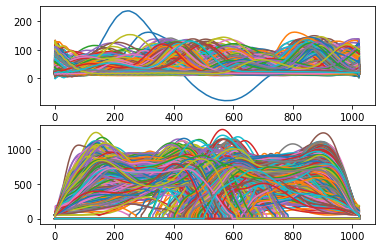

In [7]:
x = features['fm1_z'].to_numpy().reshape(-1, N_SAMPLES)
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)

plt.subplot(2, 1, 1)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

plt.subplot(2, 1, 2)
for i in range(y.shape[0]):
    plt.plot(y[i, :])